1. Take network config from MNIST Dropout experiment +
2. Take p_fail_inference from the same experiment, choose p_fail_train from CV
p_fail_train = 0.02, p_fail_inference = 0.05
3. Try regularizing with the bound by subclassing Experiment and adding a separate loss to the model +
4. Compare BestDropout vs Bestv3Regularization vs Bestv4Regularization

Note that this method does not require any randomness, so even if it's as good as dropout, it still makes a difference. The problem might be that computing the gradient of the gradient is costly... However, the dimensionality stays the same

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
# network configuration
N = [100, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
# @see ComparisonIncreasingDropoutMNIST.ipynb
p_inference = get_p_arr(0.05)

# prob. of failure at train
# @see ComparisonIncreasingDropoutMNIST.ipynb
p_train = get_p_arr(0.02)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# @see ComparisonIncreasingDropoutMNIST.ipynb
repetitions = 6

# number of runs for each regularization coefficient
runs = 5

# using v3 because v4 is too slow (16 seconds vs 30 seconds)
reg_bound = 'v3'
reg_bound_coeffs = np.logspace(-5, 2, 5)

In [3]:
class MNISTExperimentRegularized(TrainExperiment):
    def __init__(self, N, p_inference = None, p_train = None, KLips = 1, epochs = 20, activation = 'sigmoid',
                 reg_type = None, reg_coeff = 0.01, do_print = False, name = 'exp', seed = 0,
                 batch_size = 10000, reg_bound = None, reg_bound_coeff = 0.0):
        """ Get a trained with MSE loss network with configuration (N, P, activation) and reg_type(reg_coeff) with name. The last layer is linear
                N: array with shapes [hidden1, hidden2, ..., hiddenLast]. Input and output shapes are determined automatically
                p_inference: array with [p_input, p_h1, ..., p_hlast, p_output]: inference failure probabilities
                Ptrain: same for the train
                Regularizes the network with the v3 bound
                Set reg_bound to v2/v3/v4 string and reg_bound_coeff to some value
        """
        
        # remembering the dataset
        self.x_train, self.y_train, self.x_test, self.y_test = get_mnist(out_max = 1.0, in_max = 1.0)
        x_train, y_train, x_test, y_test = self.x_train, self.y_train, self.x_test, self.y_test

        # fixing Pinference
        if p_inference == None:
            p_inference = [0] * (len(N) + 2)

        # fixing Ptrain
        if p_train == None:
            p_train = [0] * (len(N) + 2)

        # obtaining input/output shape
        input_shape = x_train[0].size
        output_shape = y_train[0].size

        # full array of shapes
        N = [input_shape] + N + [output_shape]

        # input check
        assert len(p_inference) == len(p_train), "Pinference and p_train must have the same length"
        assert len(N) == len(p_train), "Ptrain must have two more elements compared to N"
        assert input_shape > 0, "Input must exist"
        assert output_shape > 0, "Output must exist"

        # filling in the task
        self.task = 'classification'
        
        # seeding the weights generation
        np.random.seed(seed)

        # creating weight initialization
        W, B = [], []
        for i in range(1, len(N)):
            W += [np.random.randn(N[i], N[i - 1]) * np.sqrt(2. / N[i - 1]) / KLips]
            B += [np.random.randn(N[i])]

        # print?
        do_print_ = True if do_print == True else False
    
        # by default, no regularization with a bound
        bound_loss = tf.Variable(0.0)
    
        # creating a model
        model, parameters = create_fc_crashing_model(N, W, B, p_train, KLips = KLips, func = activation,
                                         reg_type = reg_type, reg_coeff = reg_coeff, do_print = do_print_,
                                         do_compile = False)
        
        # saving parameters to allow for the bound method to create the graph...
        self.p_inference = p_inference
        self.N = N
        self.model_correct = model
    
        # if bound type is set...
        if reg_bound:
            # obtaining the bound method by name
            bound_method = getattr(self, 'get_bound_%s' % reg_bound)

            # calling on some dummy data to create the graph
            bound_method(np.random.randn(1, N[0]))
            
            # obtaining the std bound graph
            bound_loss = getattr(self, '__cache_get_bound_%s_get_graph_args_()_kwargs_{}' % reg_bound)['std'] ** 2
            
            # regularization = coeff * mean over the dataset
            bound_loss = tf.reduce_mean(bound_loss) * reg_bound_coeff
        
        # obtaining its original loss
        orig_loss = parameters['loss']
        
        # adding bound loss to parameter
        parameters['loss'] = lambda y_true, y_pred: orig_loss(y_true, y_pred) + bound_loss
        
        # compiling the model
        model.compile(**parameters)
    
        # fitting the model on the train data
        history = model.fit(x_train, y_train, verbose = do_print_, batch_size = batch_size, epochs = epochs, validation_data = (x_test, y_test))
    
        # plotting the loss
        if do_print and epochs > 0:
    
          # determining what to plot (target)
          if self.task == 'classification':
            target = 'categorical_accuracy'
          else: raise NotImplementedError("Plotting for this task is not supported")
    
          # plotting
          plt.figure()
          plt.plot(history.history['val_' + target], label = 'val_' + target)
          plt.plot(history.history[target], label = target)
          plt.legend()
          plt.savefig('training_' + name + '.png')
          plt.show()
        
          # plotting
          plt.figure()
          plt.plot(history.history['loss'], label = 'loss')
          plt.legend()
          plt.show()
    
        # obtaining trained weights and biases
        W = model.get_weights()[0::2]
        W = [w.T for w in W]
        B = model.get_weights()[1::2]
    
        # creating "crashing" and "normal" models
        Experiment.__init__(self, N, W, B, p_inference, KLips = KLips, activation = activation, do_print = do_print_, name = name)

In [ ]:
def get_results(reg_bound_coeff):
    # obtaining the distribution after 10 epochs
    results = []
    
    def unravel(name, data):
        return {name + '_' + key: data[key] for key in data.keys()}
    
    for _ in tqdm(range(runs)):
        exp = MNISTExperimentRegularized(N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = 'plot',
                                      name = 'experiment_regularization', seed = None, batch_size = 100, reg_bound_coeff = reg_bound_coeff)
        
        results += [{**unravel('correct_acc', exp.get_accuracy_correct(test_only = True)), # test_only = True
                     **unravel('crashing_acc', exp.get_accuracy_crash(test_only = True, repetitions = repetitions)), # test_only = True
                     
                     **unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                     
                     'v1_infnorm_mean': np.mean(exp.get_bound_v1_infnorm(exp.x_train)['mean']),
                    }]
        
        # freeing up the memory
        K.clear_session()
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

In [ ]:
# Baseline (Dropout): 

  0%|          | 0/5 [00:00<?, ?it/s]

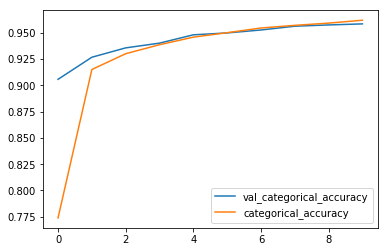

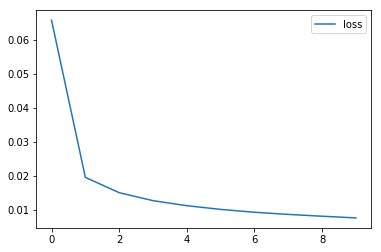

 20%|██        | 1/5 [00:18<01:12, 18.23s/it]

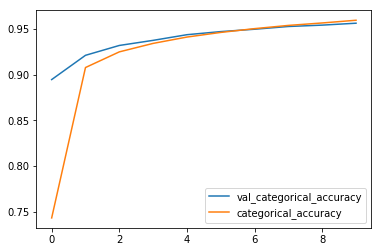

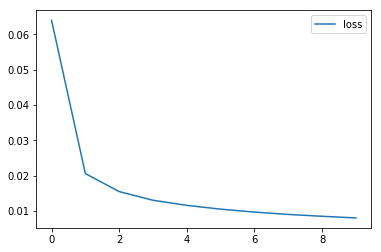

 40%|████      | 2/5 [00:36<00:55, 18.34s/it]

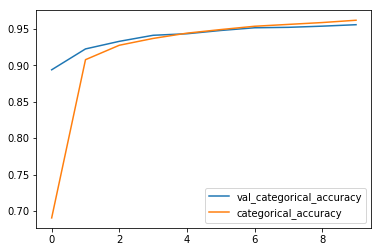

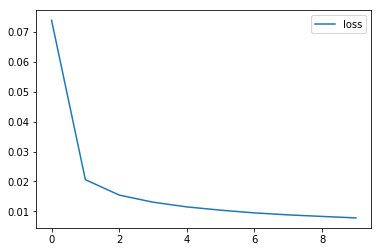

 60%|██████    | 3/5 [00:55<00:36, 18.46s/it]

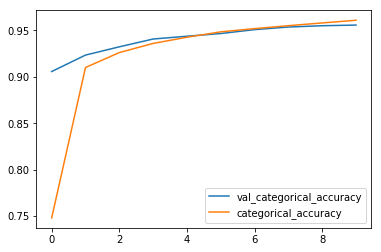

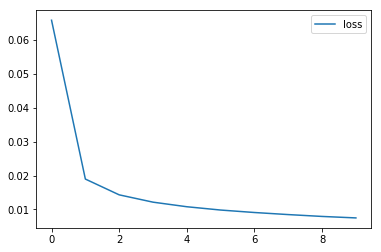

 80%|████████  | 4/5 [01:14<00:18, 18.55s/it]

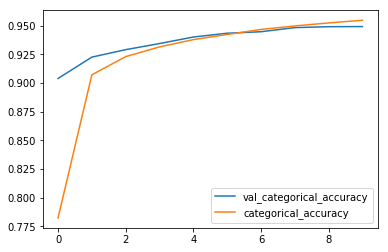

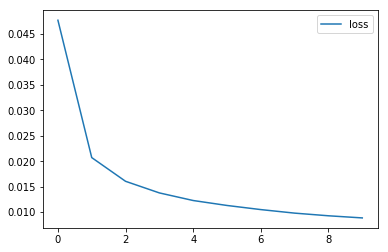

In [ ]:
# obtaining results
results_array = [get_results(reg_bound_coeff) for reg_bound_coeff in reg_bound_coeffs]

In [ ]:
save_fn = 'Regularization.ipynb.pkl'
pickle.dump(results_array, open(save_fn, 'wb'))
#results_array = pickle.load(open(save_fn, 'rb'))

Dropout baseline
![ACC dropout](figures/comparison_acc_do_mnist.png) ![MAE Dropout](figures/comparison_mae_do_mnist.png)